In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


In [289]:
NIGHT_PRICE = 7.05
DAY_PRICE = 8.68
NIGHT_MOVING_PRICE = 1.45080
DAY_MOVING_PRICE = 3.37280
ADDITIONAL_MOVING_PRICE = 2.79372

In [290]:
hourly = pd.read_excel("data/electricity_consumption.xlsx", sheet_name="hourly")
hourly_detailed = pd.read_excel("data/electricity_consumption.xlsx", sheet_name="hourly_detailed")
weather = pd.read_csv("data/weather.csv")

hourly


,timestamp,consumption
0,1.1.2022 00:00,0.00
1,1.1.2022 01:00,0.00
2,1.1.2022 02:00,0.00
3,1.1.2022 03:00,0.00
4,1.1.2022 04:00,0.00
...,...,...
9523,1.2.2023 19:00,3.96
9524,1.2.2023 20:00,3.65
9525,1.2.2023 21:00,2.46
9526,1.2.2023 22:00,3.27


Timestamp to be interpeted this way: If ts = 22:00, then the consumption is from between 22:00-23:00

In [291]:
hourly["timestamp"] = pd.to_datetime(hourly["timestamp"], format="%d.%m.%Y %H:%M")
hourly["timestamp"] = hourly["timestamp"].dt.tz_localize("Europe/Helsinki", ambiguous='infer')
hourly

,timestamp,consumption
0,2022-01-01 00:00:00+02:00,0.00
1,2022-01-01 01:00:00+02:00,0.00
2,2022-01-01 02:00:00+02:00,0.00
3,2022-01-01 03:00:00+02:00,0.00
4,2022-01-01 04:00:00+02:00,0.00
...,...,...
9523,2023-02-01 19:00:00+02:00,3.96
9524,2023-02-01 20:00:00+02:00,3.65
9525,2023-02-01 21:00:00+02:00,2.46
9526,2023-02-01 22:00:00+02:00,3.27


In [292]:
weather["timestamp"] = pd.to_datetime(weather[["Year", "m", "d", "Time"]].astype(str).agg(' '.join, axis=1), format='%Y %m %d %H:%M:%S')
weather["timestamp"] = weather["timestamp"].dt.tz_localize("UTC")
weather["timestamp"] = weather["timestamp"].dt.tz_convert("Europe/Helsinki")
weather = weather.drop(columns=["Time zone", "Year", "m", "d", "Time"])
weather

,Cloud amount (1/8),Pressure (msl) (hPa),Precipitation amount (mm),Relative humidity (%),Precipitation intensity (mm/h),Snow depth (cm),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),timestamp
0,-,1003.7,-,88,-,-,-4.5,-6.2,-,345,7.4,4.4,2022-01-01 02:00:00+02:00
1,-,1004.7,-,89,-,-,-4.7,-6.1,-,353,10.1,8.5,2022-01-01 03:00:00+02:00
2,-,1005.5,-,90,-,-,-4.4,-5.7,-,347,7.9,6.5,2022-01-01 04:00:00+02:00
3,-,1006.2,-,87,-,-,-4.3,-6.2,-,346,10.6,9.1,2022-01-01 05:00:00+02:00
4,-,1007.5,-,85,-,-,-4.6,-6.8,-,356,11.2,8.3,2022-01-01 06:00:00+02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9188,-,997.8,-,93,-,-,-1.9,-2.9,-,77,2.2,1.8,2023-02-01 22:00:00+02:00
9189,-,998.4,-,94,-,-,-1.9,-2.7,-,348,2.6,2.2,2023-02-01 23:00:00+02:00
9190,-,999,-,95,-,-,-2.1,-2.7,-,355,2.5,1.7,2023-02-02 00:00:00+02:00
9191,-,999.4,-,96,-,-,-2.1,-2.6,-,335,3.3,2.9,2023-02-02 01:00:00+02:00


In [293]:
numerical_columns = [col for col in weather.columns if col != "timestamp"]
weather[numerical_columns] = weather[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [294]:
weahter_shifted = weather.shift(-1)
numerical_columns = weather.select_dtypes(include=[np.number]).columns.tolist()
weather_averaged = (weather[numerical_columns] + weahter_shifted[numerical_columns]) / 2
weather_averaged["timestamp"] = weather["timestamp"]
weather_averaged

,Cloud amount (1/8),Pressure (msl) (hPa),Precipitation amount (mm),Relative humidity (%),Precipitation intensity (mm/h),Snow depth (cm),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),timestamp
0,NaN,1004.20,NaN,88.5,NaN,NaN,-4.60,-6.15,NaN,349.0,8.75,6.45,2022-01-01 02:00:00+02:00
1,NaN,1005.10,NaN,89.5,NaN,NaN,-4.55,-5.90,NaN,350.0,9.00,7.50,2022-01-01 03:00:00+02:00
2,NaN,1005.85,NaN,88.5,NaN,NaN,-4.35,-5.95,NaN,346.5,9.25,7.80,2022-01-01 04:00:00+02:00
3,NaN,1006.85,NaN,86.0,NaN,NaN,-4.45,-6.50,NaN,351.0,10.90,8.70,2022-01-01 05:00:00+02:00
4,NaN,1008.20,NaN,86.5,NaN,NaN,-5.50,-7.45,NaN,344.0,8.70,6.60,2022-01-01 06:00:00+02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9188,NaN,998.10,NaN,93.5,NaN,NaN,-1.90,-2.80,NaN,212.5,2.40,2.00,2023-02-01 22:00:00+02:00
9189,NaN,998.70,NaN,94.5,NaN,NaN,-2.00,-2.70,NaN,351.5,2.55,1.95,2023-02-01 23:00:00+02:00
9190,NaN,999.20,NaN,95.5,NaN,NaN,-2.10,-2.65,NaN,345.0,2.90,2.30,2023-02-02 00:00:00+02:00
9191,NaN,999.70,NaN,96.0,NaN,NaN,-2.10,-2.60,NaN,340.0,3.00,2.65,2023-02-02 01:00:00+02:00


In [295]:
weather_averaged = weather_averaged.dropna(axis=1, how="all")
weather_averaged

,Pressure (msl) (hPa),Relative humidity (%),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),timestamp
0,1004.20,88.5,-4.60,-6.15,349.0,8.75,6.45,2022-01-01 02:00:00+02:00
1,1005.10,89.5,-4.55,-5.90,350.0,9.00,7.50,2022-01-01 03:00:00+02:00
2,1005.85,88.5,-4.35,-5.95,346.5,9.25,7.80,2022-01-01 04:00:00+02:00
3,1006.85,86.0,-4.45,-6.50,351.0,10.90,8.70,2022-01-01 05:00:00+02:00
4,1008.20,86.5,-5.50,-7.45,344.0,8.70,6.60,2022-01-01 06:00:00+02:00
...,...,...,...,...,...,...,...,...
9188,998.10,93.5,-1.90,-2.80,212.5,2.40,2.00,2023-02-01 22:00:00+02:00
9189,998.70,94.5,-2.00,-2.70,351.5,2.55,1.95,2023-02-01 23:00:00+02:00
9190,999.20,95.5,-2.10,-2.65,345.0,2.90,2.30,2023-02-02 00:00:00+02:00
9191,999.70,96.0,-2.10,-2.60,340.0,3.00,2.65,2023-02-02 01:00:00+02:00


In [296]:
all_data = pd.merge(hourly, weather_averaged, on="timestamp")
all_data

,timestamp,consumption,Pressure (msl) (hPa),Relative humidity (%),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,2022-01-01 02:00:00+02:00,0.00,1004.20,88.5,-4.60,-6.15,349.0,8.75,6.45
1,2022-01-01 03:00:00+02:00,0.00,1005.10,89.5,-4.55,-5.90,350.0,9.00,7.50
2,2022-01-01 04:00:00+02:00,0.00,1005.85,88.5,-4.35,-5.95,346.5,9.25,7.80
3,2022-01-01 05:00:00+02:00,0.00,1006.85,86.0,-4.45,-6.50,351.0,10.90,8.70
4,2022-01-01 06:00:00+02:00,0.00,1008.20,86.5,-5.50,-7.45,344.0,8.70,6.60
...,...,...,...,...,...,...,...,...,...
9185,2023-02-01 19:00:00+02:00,3.96,996.65,88.0,-1.10,-2.80,212.0,2.90,2.35
9186,2023-02-01 20:00:00+02:00,3.65,997.10,85.0,-1.15,-3.35,228.5,2.30,1.80
9187,2023-02-01 21:00:00+02:00,2.46,997.55,88.5,-1.55,-3.20,160.0,1.60,1.20
9188,2023-02-01 22:00:00+02:00,3.27,998.10,93.5,-1.90,-2.80,212.5,2.40,2.00


In [297]:
start_date = pd.Timestamp('2022-02-01', tz='Europe/Helsinki')
end_date = pd.Timestamp('2023-01-31', tz='Europe/Helsinki')

filtered_df = all_data[(all_data['timestamp'] >= start_date) & (all_data['timestamp'] <= end_date)]


filtered_df

,timestamp,consumption,Pressure (msl) (hPa),Relative humidity (%),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
742,2022-02-01 00:00:00+02:00,1.32,1000.90,89.0,-10.30,-11.80,346.0,6.00,5.40
743,2022-02-01 01:00:00+02:00,1.96,1000.65,88.5,-10.35,-11.90,345.0,6.90,6.20
744,2022-02-01 02:00:00+02:00,5.30,1000.60,88.0,-10.40,-12.05,341.0,6.40,5.75
745,2022-02-01 03:00:00+02:00,2.06,1000.45,88.0,-10.40,-12.10,341.0,5.75,5.20
746,2022-02-01 04:00:00+02:00,1.15,1000.30,87.5,-10.50,-12.15,340.0,5.60,4.85
...,...,...,...,...,...,...,...,...,...
9138,2023-01-30 20:00:00+02:00,2.02,974.15,91.5,-0.30,-1.60,305.5,13.30,9.05
9139,2023-01-30 21:00:00+02:00,4.27,975.65,89.0,-0.80,-2.45,306.0,13.20,8.95
9140,2023-01-30 22:00:00+02:00,6.66,977.10,88.0,-1.25,-3.00,301.5,12.95,8.35
9141,2023-01-30 23:00:00+02:00,3.25,978.45,84.0,-1.60,-3.90,303.0,12.95,8.90


In [298]:
def get_list_price(hour):
    if 22 <= hour or hour < 6:
        return NIGHT_PRICE
    else:
        return DAY_PRICE

def get_moving_price(hour):
    if 22 <= hour or hour < 6:
        return NIGHT_MOVING_PRICE  + ADDITIONAL_MOVING_PRICE 
    else:
        return DAY_MOVING_PRICE + ADDITIONAL_MOVING_PRICE 


filtered_df = filtered_df.copy()
filtered_df.loc[:, 'kwh_price'] = filtered_df['timestamp'].dt.hour.map(get_list_price)
filtered_df.loc[:, 'kwh_moving_price'] = filtered_df['timestamp'].dt.hour.map(get_moving_price)
filtered_df["total_price"] = filtered_df["kwh_price"] + filtered_df["kwh_moving_price"]
filtered_df["costs_eur"] = filtered_df["kwh_price"] * filtered_df["consumption"] / 100
filtered_df["moving_costs_eur"] = filtered_df["kwh_moving_price"] * filtered_df["consumption"] / 100
filtered_df["total_costs_eur"] = filtered_df["total_price"] * filtered_df["consumption"] / 100
filtered_df

,timestamp,consumption,Pressure (msl) (hPa),Relative humidity (%),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),kwh_price,kwh_moving_price,total_price,costs_eur,moving_costs_eur,total_costs_eur
742,2022-02-01 00:00:00+02:00,1.32,1000.90,89.0,-10.30,-11.80,346.0,6.00,5.40,7.05,4.24452,11.29452,0.093060,0.056028,0.149088
743,2022-02-01 01:00:00+02:00,1.96,1000.65,88.5,-10.35,-11.90,345.0,6.90,6.20,7.05,4.24452,11.29452,0.138180,0.083193,0.221373
744,2022-02-01 02:00:00+02:00,5.30,1000.60,88.0,-10.40,-12.05,341.0,6.40,5.75,7.05,4.24452,11.29452,0.373650,0.224960,0.598610
745,2022-02-01 03:00:00+02:00,2.06,1000.45,88.0,-10.40,-12.10,341.0,5.75,5.20,7.05,4.24452,11.29452,0.145230,0.087437,0.232667
746,2022-02-01 04:00:00+02:00,1.15,1000.30,87.5,-10.50,-12.15,340.0,5.60,4.85,7.05,4.24452,11.29452,0.081075,0.048812,0.129887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9138,2023-01-30 20:00:00+02:00,2.02,974.15,91.5,-0.30,-1.60,305.5,13.30,9.05,8.68,6.16652,14.84652,0.175336,0.124564,0.299900
9139,2023-01-30 21:00:00+02:00,4.27,975.65,89.0,-0.80,-2.45,306.0,13.20,8.95,8.68,6.16652,14.84652,0.370636,0.263310,0.633946
9140,2023-01-30 22:00:00+02:00,6.66,977.10,88.0,-1.25,-3.00,301.5,12.95,8.35,7.05,4.24452,11.29452,0.469530,0.282685,0.752215
9141,2023-01-30 23:00:00+02:00,3.25,978.45,84.0,-1.60,-3.90,303.0,12.95,8.90,7.05,4.24452,11.29452,0.229125,0.137947,0.367072


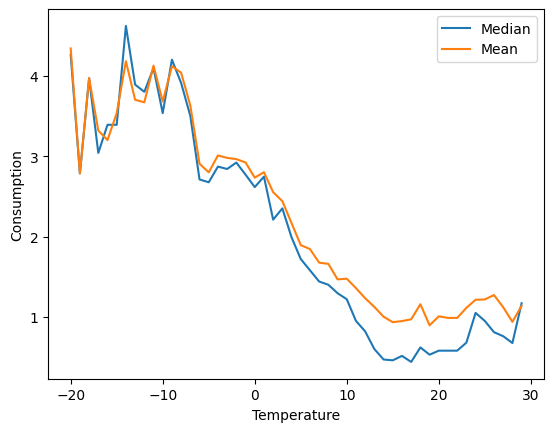

In [301]:
df = filtered_df

df["temperature_group"] = (df["Air temperature (degC)"]).round()
grouped = df.groupby("temperature_group")
median = grouped["consumption"].median()
mean = grouped["consumption"].mean()

# Plot the scatter plot with the median and average lines
#plt.scatter(df["Air temperature (degC)"], df["consumption"])
plt.plot(median.index, median.values, label="Median")
plt.plot(mean.index, mean.values, label="Mean")
plt.xlabel("Temperature")
plt.ylabel("Consumption")
plt.legend()
plt.show()


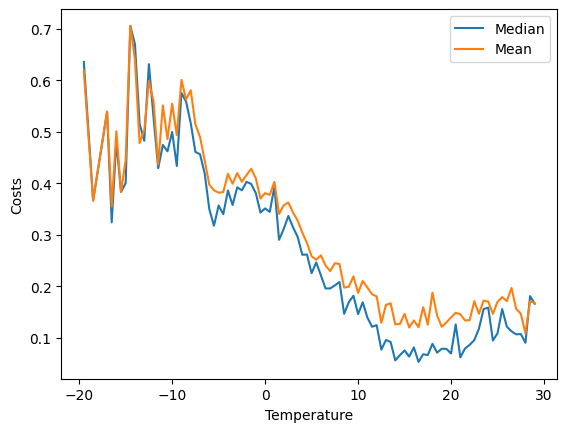

In [300]:
df = filtered_df

df["temperature_group"] = (df["Air temperature (degC)"] * 2).round() / 2
grouped = df.groupby("temperature_group")
median = grouped["total_costs_eur"].median()
mean = grouped["total_costs_eur"].mean()

# Plot the scatter plot with the median and average lines
#plt.scatter(df["Air temperature (degC)"], df["consumption"])
plt.plot(median.index, median.values, label="Median")
plt.plot(mean.index, mean.values, label="Mean")
plt.xlabel("Temperature")
plt.ylabel("Costs")
plt.legend()
plt.show()

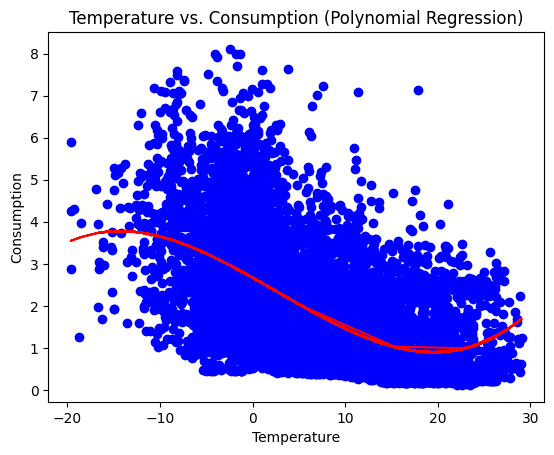

In [318]:

def drop_outliers(df, column_name, threshold=3):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z = (df[column_name] - mean) / std
    df = df[(z < threshold) & (z > -threshold)]
    return df


df = filtered_df.dropna(subset=["Air temperature (degC)", 'consumption'])
df = drop_outliers(df, "consumption", threshold=4)

x = df[["Air temperature (degC)"]].values
y = df[['consumption']].values

# Transform input data to polynomial features
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)

# Train the polynomial regression model
reg = LinearRegression().fit(x_poly, y)

# Predict the consumption based on temperature
y_pred = reg.predict(x_poly)

# Plot the input data and the regression line
plt.scatter(x, y, color='blue')
plt.plot(x, y_pred, color='red')
plt.xlabel('Temperature')
plt.ylabel('Consumption')
plt.title('Temperature vs. Consumption (Polynomial Regression)')
plt.show()

In [320]:
reg.predict(12)

ValueError: Expected 2D array, got scalar array instead:
array=12.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.